# Identification of Age-related Macular Degeneration among Retinal Images obtained via Optical Coherence Tomography

## By Rami Dabit and Terry Wang

UCSB ECE 194N/594N Nina Miolane

***

## Question

**Given some sets of retinal OCT image data, is it possible to computationally aid ophthalmologists in tasks such as identification of age-related macular degeneration using anatomical landmark detection and shape analysis?**

## I. Introduction

Age-related macular degeneration (AMD) is an eye disease and leading cause of vision loss for older adults affecting approximately one in ten Americans aged 50 and older. Blurring the central vision, AMD can make it difficult for a patient to see details straight ahead or in low lighting. With age, one may notice that lines in their central field of view begin to appear wavy or crooked, and many with AMD experience a growing area of blurriness or even blank spot in their central vision later in life.

This disease is characterized by damage to the retina, the light-sensitive tissue at the back of the eye, and with shape analysis, it may be possible to identify AMD using common imaging techniques in the field of ophthalmology; for example, Optical Coherence Tomography (OCT), which captures a number of slices of the region of interest (i.e., retina of patients in a study). The OCTID dataset offers three image sets of interest: 206 fovea-centered OCT images of healthy adult retina [[3]](https://doi.org/10.5683/SP/WLW4ZT), 55 fovea-centered OCT images of adult retina diagnosed with AMD [[4]](https://doi.org/10.5683/SP/YEM3RA), and 102 fovea-centered OCT images of adult retina containing a macular hole [[5]](https://doi.org/10.5683/SP/MBMQGD), an indicator of potential age-related macular degeneration.

![Sample OCT Images](https://i.imgur.com/QRWjZCA.png)

## II. Related work

Although Optical Coherence Tomography was first introduced in 1991 and is a widely used imaging modality, the topic of AMD identification using such image slices has not been thoroughly explored. Only one piece of literature by Arabi et al. [[1]](https://doi.org/10.1088/1757-899X/310/1/012096) can be found on Google Scholar, where they propose a methodology of filtering grayscale versions of OCT retinal images with a Gaussian filter, enhancing using contrast stretching, and thresholding the foreground of the retina from the darker background. Then, the Retinal Pigmented Epithelium (RPE) layer is extracted and divided into eight sub-images or quadrants. Finally, the mean pixel value is calculated across the quadrants and an average mean *M* is calculated for a pair of healthy-labeled and amd-labeled images using these mean pixel values. For use as a decision rule, an *M* value greater than 125 classifies an retinal image as healthy; otherwise, the retina is classified with an AMD diagnosis.

Ghesu et al. [[2]](https://doi.org/10.1007/978-3-319-46726-9_27) instead propose a general approach for anatomical landmark detection in medical images, where such landmarks act as indicators of potential disease. Object appearance is modeled simultaneously alongside a parameter search strategy as a unified behavioral task for an artifical agent. This is achieved by way of reinforcement learning for image parsing with hierarchical feature extraction via deep learning, which the authors claim is more optimal than exhaustively scanning the entire solution space. However, in the case of AMD in retinal OCT images, the former method may be better suited to tackle the data given that a patient with a positive diagnosis will have points of hole discontinuity in the retinal scans. For this reason, we attempted the approach proposed by Arabi et al. [[1]](https://doi.org/10.1088/1757-899X/310/1/012096), but found it unreliable for landmark detection in our dataset; rather, we proceeded with our own implementation of contour extraction based on the inner and outer segment junction. The IS/OS line lies at the junction between the photoreceptor outer and inner segments, where a disturbed IS/OS line integrity serves as an indicator for not only AMD, but for many other retinal diseases as well.

## III. Approach

**Imports and setup**

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from PIL import Image

import preprocessing as pre
import is_os_line as isos
import metrics
import support_vector_classification as my_svc
%matplotlib inline

nb_path = os.path.abspath("identification_of_amd.ipynb")

In [2]:
images_normal = pre.load_images("data/OCTID_NORMAL")
images_amd = pre.load_images("data/OCTID_AMD")
images_mh = pre.load_images("data/OCTID_MH")

**IS/OS line extraction**

In [3]:
is_os_lines_normal = []
for i in range(len(images_normal)):
    img = pre.remove_background(images_normal[i])
    is_os_line = isos.extract_is_os_line(img)
    is_os_lines_normal.append(is_os_line)

is_os_lines_amd = []
for i in range(len(images_amd)):
    img = pre.remove_background(images_amd[i])
    is_os_line = isos.extract_is_os_line(img)
    is_os_lines_amd.append(is_os_line)

is_os_lines_mh = []
for i in range(len(images_mh)):
    img = pre.remove_background(images_mh[i])
    is_os_line = isos.extract_is_os_line(img)
    is_os_lines_mh.append(is_os_line)

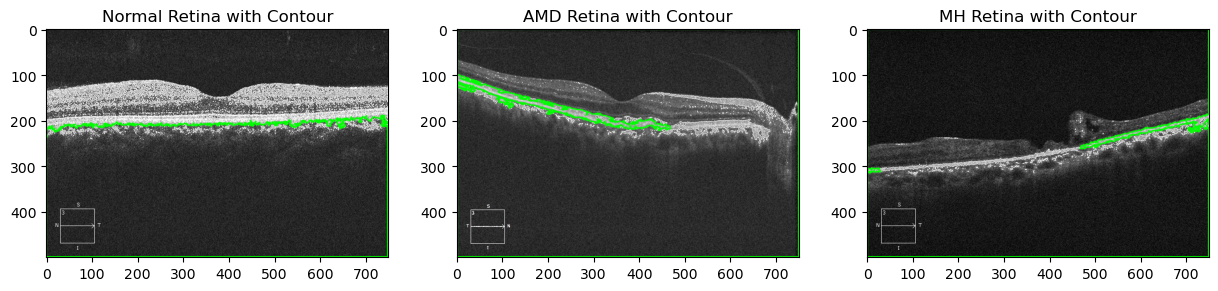

In [4]:
image_copy_normal = images_normal[0].copy()
cv2.drawContours(image=image_copy_normal, contours=is_os_lines_normal[0], 
                 contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)

image_copy_amd = images_amd[0].copy()
cv2.drawContours(image=image_copy_amd, contours=is_os_lines_amd[0], 
                 contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)

image_copy_mh = images_mh[0].copy()
cv2.drawContours(image=image_copy_mh, contours=is_os_lines_mh[0], 
                 contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)

plt.rcParams['figure.figsize'] = (15,15)
fig, ax = plt.subplots(1,3)
ax[0].imshow(image_copy_normal)
ax[0].set_title('Normal Retina with Contour')
ax[1].imshow(image_copy_amd)
ax[1].set_title('AMD Retina with Contour')
ax[2].imshow(image_copy_mh)
ax[2].set_title('MH Retina with Contour')
plt.show()

Prior to extracting the IS/OS line contour shape, we draw it over some sample input retinal scans to demonstrate a disturbance in patients with AMD and macular holes. As a general rule of thumb, we determine that patients with normal retinas will have a complete contour stretching from left-to-right.

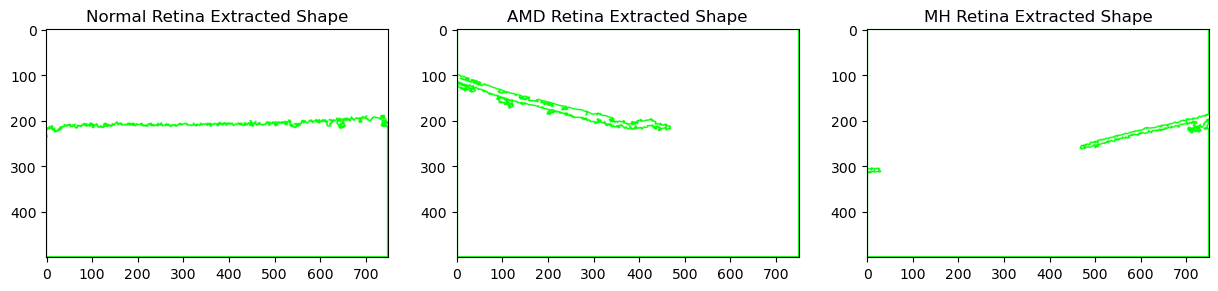

In [5]:
image_copy_normal = 255 + np.zeros_like(images_normal[0])
cv2.drawContours(image=image_copy_normal, contours=is_os_lines_normal[0], 
                 contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)

image_copy_amd = 255 + np.zeros_like(images_amd[0])
cv2.drawContours(image=image_copy_amd, contours=is_os_lines_amd[0], 
                 contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)

image_copy_mh = 255 + np.zeros_like(images_mh[0])
cv2.drawContours(image=image_copy_mh, contours=is_os_lines_mh[0], 
                 contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)

fig, ax = plt.subplots(1,3)
ax[0].imshow(image_copy_normal)
ax[0].set_title('Normal Retina Extracted Shape')
ax[1].imshow(image_copy_amd)
ax[1].set_title('AMD Retina Extracted Shape')
ax[2].imshow(image_copy_mh)
ax[2].set_title('MH Retina Extracted Shape')
plt.show()

**Shape analysis and comparison**

In [6]:
# Top-side tolerance
tol_top = 15
# Bottom-side tolerance
tol_bot = 25
# Left-hand tolerance
tol_left = 15
# Right-hand tolerance
tol_right = 25

def diff_y(img):
    """Compute vertical width of IS/OS line at each column."""
    diff_y = []
    num_rows, num_cols, _ = img.shape
    for j in range(num_cols-tol_left-tol_right):
        y_min = 0
        y_max = 0
        for i in range(num_rows-tol_top-tol_bot):
            if img[i+tol_top,j+tol_left,0] == 0 and img[i+tol_top,j+tol_left,1] == 255:
                y_min = i+tol_top
                break
        for i in range(num_rows-y_min-tol_top-tol_bot):
            if img[i+y_min,j+tol_left,0] == 0 and img[i+y_min+tol_top,j+tol_left,1] == 255:
                y_max = i+y_min+tol_top
        diff_y.append(y_max-y_min-1-tol_top)
    return diff_y

In [7]:
vwidth_normal = diff_y(image_copy_normal)
vwidth_amd = diff_y(image_copy_amd)
vwidth_mh = diff_y(image_copy_mh)

def remove_value(input_list, value):
    return [x for x in input_list if x != value]

normal_nonzero = remove_value(vwidth_normal, 0)
amd_nonzero = remove_value(vwidth_amd, 0)
mh_nonzero = remove_value(vwidth_mh, 0)

print('Average contour thickness (normal): '+ str(sum(vwidth_normal) / len(normal_nonzero)))
print('Average contour thickness (amd): '   + str(sum(vwidth_amd)    / len(amd_nonzero)))
print('Average contour thickness (mh): '    + str(sum(vwidth_mh)     / len(mh_nonzero)))

Average contour thickness (normal): 4.185915492957746
Average contour thickness (amd): 18.295154185022028
Average contour thickness (mh): 11.08029197080292


We have now achieved our first metric for shape comparison, but keeping in mind that patients with positive AMD diagnoses will have a disturbance in their IS/OS lines, we must also measure the distance of the largest horizontal gap in the contour.

In [8]:
# Keeping the same tolerances for top, bottom, left, and right...

def diff_x(img):
    """Compute horizontal width of largest gap in IS/OS line."""
    diff_x = []
    num_rows, num_cols, _ = img.shape
    for i in range(num_rows-tol_top-tol_bot):
        current_gap = 0
        largest_gap = 0
        for j in range(num_cols-tol_left-tol_right):
            if all(img[i+tol_top,j+tol_left,0] == [255,255,255]):
                current_gap += 1
                if current_gap > largest_gap:
                    largest_gap = current_gap
            else:
                current_gap = 0
        diff_x.append(largest_gap)
    return diff_x

In [9]:
hwidth_normal = diff_x(image_copy_normal)
hwidth_amd = diff_x(image_copy_amd)
hwidth_mh = diff_x(image_copy_mh)

hwidth_normal_nonmax = remove_value(hwidth_normal, max(hwidth_normal))
hwidth_amd_nonmax = remove_value(hwidth_amd, max(hwidth_amd))
hwidth_mh_nonmax = remove_value(hwidth_mh, max(hwidth_mh))

print('Average largest gap in contour line (normal): '+ str(sum(hwidth_normal_nonmax) / len(hwidth_normal_nonmax)))
print('Average largest gap in contour line (amd): '   + str(sum(hwidth_amd_nonmax)    / len(hwidth_amd_nonmax)))
print('Average largest gap in contour line (mh): '    + str(sum(hwidth_mh_nonmax)     / len(hwidth_mh_nonmax)))

Average largest gap in contour line (normal): 417.35897435897436
Average largest gap in contour line (amd): 498.0983606557377
Average largest gap in contour line (mh): 574.2619047619048


Now we are ready to plot and compare the shape information of the IS/OS line landmark we have detected.

(Although, some future refinement is clearly needed here to account for normal retina with large areas of continuity.)

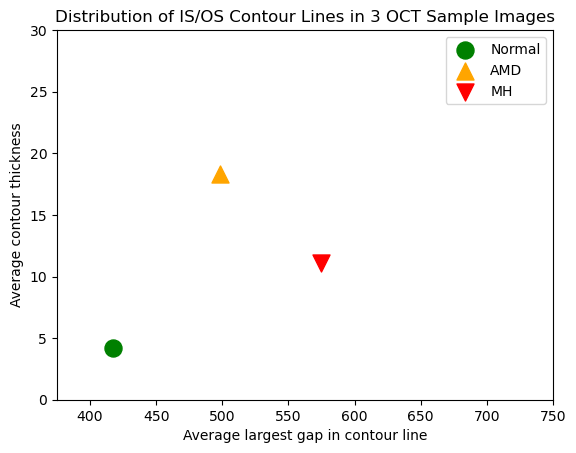

In [10]:
x_normal = sum(hwidth_normal_nonmax) / len(hwidth_normal_nonmax)
x_amd = sum(hwidth_amd_nonmax) / len(hwidth_amd_nonmax)
x_mh = sum(hwidth_mh_nonmax) / len(hwidth_mh_nonmax)
x_data = np.array([x_normal, x_amd, x_mh])

y_normal = sum(vwidth_normal) / len(normal_nonzero)
y_amd = sum(vwidth_amd) / len(amd_nonzero)
y_mh = sum(vwidth_mh) / len(mh_nonzero)
y_data = np.array([y_normal, y_amd, y_mh])

group = np.array(['Normal', 'AMD', 'MH'])
cdict = {'Normal': 'green', 'AMD': 'orange', 'MH': 'red'}
mdict = {'Normal': 'o', 'AMD': '^', 'MH': 'v'}

plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
fig, ax = plt.subplots()
for g in np.unique(group):
    idx = np.where(group == g)
    ax.scatter(x_data[idx], y_data[idx], c=cdict[g], marker=mdict[g], label=g, s=150)
ax.set_title('Distribution of IS/OS Contour Lines in 3 OCT Sample Images')
ax.set_xlabel('Average largest gap in contour line')
ax.set_ylabel('Average contour thickness')
ax.set_xlim(375, 750)
ax.set_ylim(0, 30)
order = [2, 0, 1]
handles, labels = plt.gca().get_legend_handles_labels()
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.show()

Now that we have thoroughly examined OCT image samples from three individual patients, it is time to extend the analysis to the whole dataset in hopes of finding a recognizable pattern across all patient image samples of the three types above.

In [11]:
# Pack our desired tolerance values into a tuple
tolerance = (tol_top, tol_bot, tol_left, tol_right)

# Perform the aforementioned steps across the entire dataset
coords_normal, coords_amd, coords_mh = metrics.get_metrics(images_normal, images_amd, images_mh, tolerance)

print('Number of normal points: ' + str(len(coords_normal)))
print('Number of AMD points: ' + str(len(coords_amd)))
print('Number of MH points: ' + str(len(coords_mh)))

Number of normal points: 206
Number of AMD points: 55
Number of MH points: 102


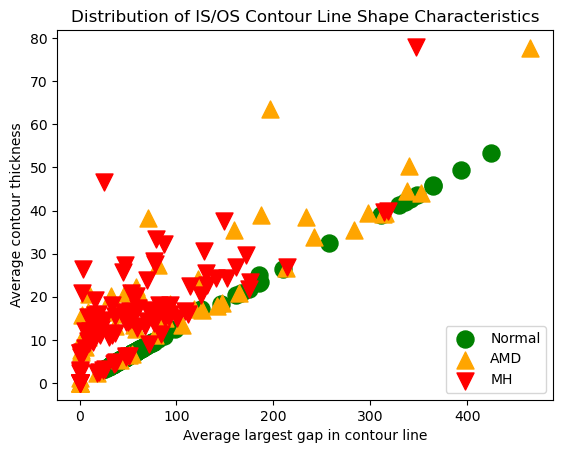

In [12]:
x_normal = []
y_normal = []
for point in coords_normal:
    x_normal.append(point[0])
    y_normal.append(point[1])
x_amd = []
y_amd = []
for point in coords_amd:
    x_amd.append(point[0])
    y_amd.append(point[1])
x_mh = []
y_mh = []
for point in coords_mh:
    x_mh.append(point[0])
    y_mh.append(point[1])

plt.scatter(x_normal, y_normal, c='green', marker='o', label='Normal', s=150)
plt.scatter(x_amd, y_amd, c='orange', marker='^', label='AMD', s=150)
plt.scatter(x_mh, y_mh, c='red', marker='v', label='MH', s=150)

plt.title('Distribution of IS/OS Contour Line Shape Characteristics')
plt.xlabel('Average largest gap in contour line')
plt.ylabel('Average contour thickness')
plt.legend(['Normal', 'AMD', 'MH'], loc=4)
plt.show()

**Support Vector Classification**

From the distribution of shape characteristics scattered above, it is apparent that the thickness and largest gap in the contour of IS/OS lines are expected to grow linearly. As such, we will use a modified version of the support vector classifier model from the scikit-learn package. The goal is to draw a best-fit line through the normal labeled data and to predict points falling far away from this line as troublesome. It is important to note, however, that the total dataset contains outliers from both positively-diagnosed classes. We see MH points in addition to AMD points along the support vector, though fortunately no normal points seem to lie outside the linear trend.

In [13]:
X_test, y_test, y_pred, accuracy = my_svc.classify_points(coords_normal, coords_amd, coords_mh, kernel='linear')

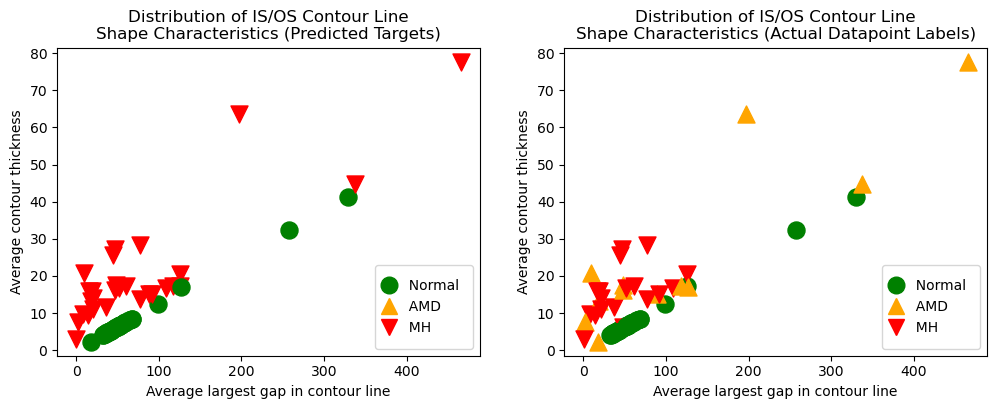

In [14]:
from matplotlib.lines import Line2D

X_test_xc = []
X_test_yc = []
X_test_label = []
X_test_target = []

for coordinate in X_test:
    X_test_xc.append(coordinate[0])
    X_test_yc.append(coordinate[1])

plt.rcParams['figure.figsize'] = (12,4)
plt.rcParams['legend.handlelength'] = 0
plt.rcParams['legend.numpoints'] = 1
fig, ax = plt.subplots(1,2)

# Plot predicted targets
for idx, target in enumerate(y_pred):
    X_test_target.append(target)
    if target == 0: # Normal prediction
        ax[0].scatter(X_test_xc[idx], X_test_yc[idx], c='green', marker='o', label='Normal', s=150)
    elif target == 1: # AMD prediction
        ax[0].scatter(X_test_xc[idx], X_test_yc[idx], c='orange', marker='^', label='AMD', s=150)
    elif target == 2: # MH prediction
        ax[0].scatter(X_test_xc[idx], X_test_yc[idx], c='red', marker='v', label='MH', s=150)

# Plot actual datapoint labels
for idx, label in enumerate(y_test):
    X_test_label.append(label)
    if label == 0: # Normal datapoint
        ax[1].scatter(X_test_xc[idx], X_test_yc[idx], c='green', marker='o', label='Normal', s=150)
    elif label == 1: # AMD datapoint
        ax[1].scatter(X_test_xc[idx], X_test_yc[idx], c='orange', marker='^', label='AMD', s=150)
    elif label == 2: # MH datapoint
        ax[1].scatter(X_test_xc[idx], X_test_yc[idx], c='red', marker='v', label='MH', s=150)

ax[0].set_title('Distribution of IS/OS Contour Line\nShape Characteristics '
                '(Predicted Targets)')
ax[1].set_title('Distribution of IS/OS Contour Line\nShape Characteristics '
                '(Actual Datapoint Labels)')

legend_elements = [Line2D([0], [0], marker='o', color='green', label='  Normal', markersize=12),
                   Line2D([0], [0], marker='^', color='orange', label='  AMD', markersize=12),
                   Line2D([0], [0], marker='v', color='red', label='  MH', markersize=12)]
for i in range(2):
    ax[i].set_xlabel('Average largest gap in contour line')
    ax[i].set_ylabel('Average contour thickness')
    ax[i].legend(handles=legend_elements, borderpad=1, loc=4)
plt.show()

In [15]:
print('Accuracy of linear SVC Model: ' + str(round(100*accuracy, 2)) + '%')

Accuracy of linear SVC Model: 80.82%


As shown in the above plot of predicted targets, the support vector classifier with linear kernel was able to successfully detect instances of disturbed IS/OS contour shapes, doing so with an accuracy of 80.82% albeit without any instances of AMD-positive diagnoses. This is understandable as drawing a best-fit line and measuring distances away from it provides no information about the type of retinal scan. Additionally, the given dataset contains almost twice as many macular hole samples than the number of AMD samples. It is yet remarkable that the SVC model was able to correctly classify disturbed points so close to normal points.

In an attempt to improve these results, we will next perform support vector classification using a radial basis function kernel, also known as RBF SVC, as opposed to its linear counterpart.

In [16]:
X_test, y_test, y_pred, accuracy = my_svc.classify_points(coords_normal, coords_amd, coords_mh, kernel='rbf')

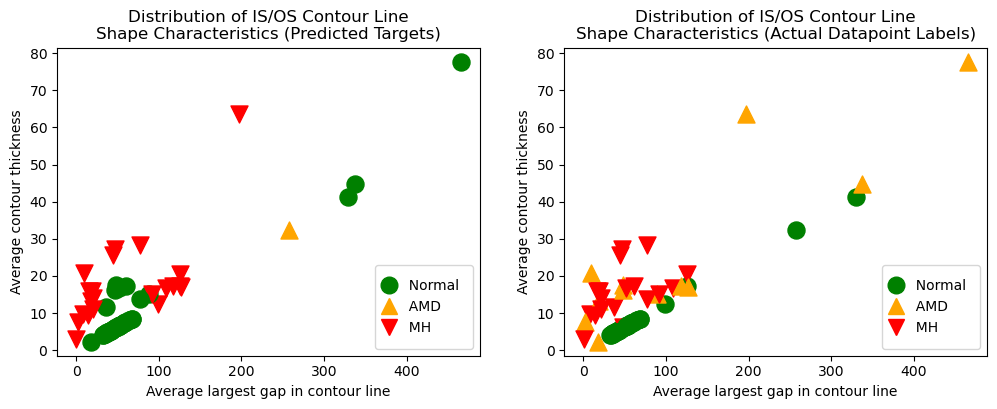

In [17]:
X_test_xc = []
X_test_yc = []
X_test_label = []
X_test_target = []

for coordinate in X_test:
    X_test_xc.append(coordinate[0])
    X_test_yc.append(coordinate[1])

fig, ax = plt.subplots(1,2)

# Plot predicted targets
for idx, target in enumerate(y_pred):
    X_test_target.append(target)
    if target == 0: # Normal prediction
        ax[0].scatter(X_test_xc[idx], X_test_yc[idx], c='green', marker='o', label='Normal', s=150)
    elif target == 1: # AMD prediction
        ax[0].scatter(X_test_xc[idx], X_test_yc[idx], c='orange', marker='^', label='AMD', s=150)
    elif target == 2: # MH prediction
        ax[0].scatter(X_test_xc[idx], X_test_yc[idx], c='red', marker='v', label='MH', s=150)

# Plot actual datapoint labels
for idx, label in enumerate(y_test):
    X_test_label.append(label)
    if label == 0: # Normal datapoint
        ax[1].scatter(X_test_xc[idx], X_test_yc[idx], c='green', marker='o', label='Normal', s=150)
    elif label == 1: # AMD datapoint
        ax[1].scatter(X_test_xc[idx], X_test_yc[idx], c='orange', marker='^', label='AMD', s=150)
    elif label == 2: # MH datapoint
        ax[1].scatter(X_test_xc[idx], X_test_yc[idx], c='red', marker='v', label='MH', s=150)

ax[0].set_title('Distribution of IS/OS Contour Line\nShape Characteristics '
                '(Predicted Targets)')
ax[1].set_title('Distribution of IS/OS Contour Line\nShape Characteristics '
                '(Actual Datapoint Labels)')

for i in range(2):
    ax[i].set_xlabel('Average largest gap in contour line')
    ax[i].set_ylabel('Average contour thickness')
    ax[i].legend(handles=legend_elements, borderpad=1, loc=4)
plt.show()

In [18]:
print('Accuracy of RBF SVC Model: ' + str(round(100*accuracy, 2)) + '%')

Accuracy of RBF SVC Model: 72.6%


In the case of classifying these shape characteristics, it seems that linear SVC is better suited to tackle the task than RBF SVC, yielding an accuracy of 80.82% compared to 72.6% respectively. On the positive side, the RBF classifier is able to perform non-binary classification and results in an AMD prediction, though incorrectly as it corresponds to a normal-label sample. As another alternative, we may also choose to classify the OCTID images directly rather than classifying them based on their extracted landmarks. This might provide an interesting comparison between direct classification of labeled data samples and classification by way of artificially chosen landmarks.

Accuracy of linear SVC Model: 95.89%


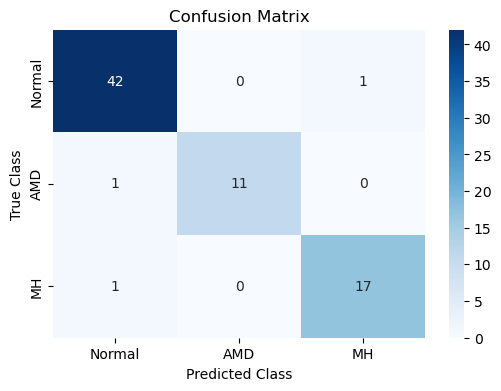

Accuracy of RBF SVC Model: 95.89%


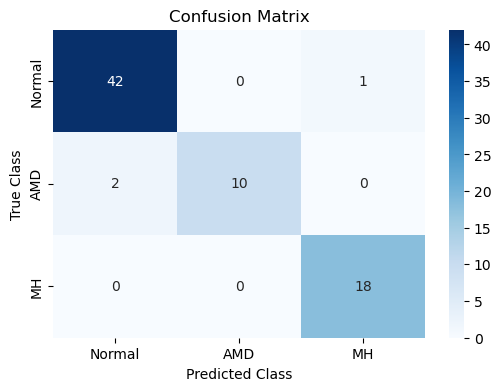

In [19]:
X_test, y_test, y_pred, accuracy = my_svc.classify_images(images_normal, images_amd, images_mh, kernel='linear')
print('Accuracy of linear SVC Model: ' + str(round(100*accuracy, 2)) + '%')
my_svc.show_confusion_matrix(y_test, y_pred)

X_test, y_test, y_pred, accuracy = my_svc.classify_images(images_normal, images_amd, images_mh, kernel='rbf')
print('Accuracy of RBF SVC Model: ' + str(round(100*accuracy, 2)) + '%')
my_svc.show_confusion_matrix(y_test, y_pred)

When running linear and RBF support vector classification directly on the images from the dataset, our accuracy improves significantly to 95.89%: an increase of approximately 15% and 23% compared to contour shape classification. This leads us to believe that the IS/OS line is not a complete indicator of AMD or macular holes, which is to be expected given that it is only one layer of the ten-layer retinal scans. While it may be the most evident hyper-reflective band in the retina, it might not be the best indicator of age-related macular degeneration; nevertheless, it still has the potential to be useful in late-stage diagnoses where retinal detachment is more likely and loss of sight is near.

## IV. Results

In the above approach, we have analyzed Optical Coherence Tomography Imade Data [[3]](https://doi.org/10.5683/SP/WLW4ZT) [[4]](https://doi.org/10.5683/SP/YEM3RA) [[5]](https://doi.org/10.5683/SP/MBMQGD) based on the shape of the inner and outer segment junction found in the retina of adult patients. Performing landmark extraction of the IS/OS contour in the 363 retinal images proved to be a suboptimal, yet still impressive landmark method for identification of diseased retinas. Given that the retina is comprised of ten layers and the IS/OS line is only one of those ten, classifying the labeled scans directly results in a learning process with much more information at hand. In the future, more landmarks should be extracted and analyzed, such as large quantities of drusen or deposits under the retina associated with increased risk of macular disease. That being said, a linear SVC accuracy score of 80.82% with the option of improving to 95.89% accuracy is not too shabby, keeping in mind that only 73 samples are reserved for testing.

Our earlier hypothesis stands: patients who are at risk of vision loss due to AMD are likely to have various extents of discontinuity in their IS/OS contour lines, as well as a greater thickness in this line stemming from an unusual contour shape. Meanwhile, adults with healthy vision are more likely to bear slim and straight retinas with intact foveas, growing the two metrics according to a linear trend. With this information, ophthalmologists may be able to detect outliers and warn patients of the potential damage to their central field of vision before their condition becomes severe and risk of becoming blind is high.

## V. Future Directions

Down the road, it would be interesting to try the landmark extraction method proposed by Ghesu et al. [[2]](https://doi.org/10.1007/978-3-319-46726-9_27) given that our IS/OS contours are far from perfect. We believe that better anatomical landmarks will help increase the accuracy of support vector classifier to a value closer to 95.89%. Another goal to work toward is refining and optimizing the metrics produced above, and to ensure they work well on a larger-scale datasets. A greater number of image samples is critical to achieving good results, and the small size of the dataset in this project has certainly been a limitation. The sky is the limit in this growing field of computational biology, computational medicine, and the intersection between machine learning and ophthalmology.

## References

[[1]](https://doi.org/10.1088/1757-899X/310/1/012096) Arabi, Punal M., Nanditha Krishna, V. Ashwini, and H. M. Prathibha. "Identification of age-related macular degeneration using oct images." In *IOP Conference Series: Materials Science and Engineering,* vol. 310, no. 1, p. 012096. IOP Publishing, 2018.

[[2]](https://doi.org/10.1007/978-3-319-46726-9_27) Ghesu, Florin C., Bogdan Georgescu, Tommaso Mansi, Dominik Neumann, Joachim Hornegger, and Dorin Comaniciu. "An artificial agent for anatomical landmark detection in medical images." In *Medical Image Computing and Computer-Assisted Intervention-MICCAI 2016: 19th International Conference, Athens, Greece, October 17-21, 2016, Proceedings, Part III 19,* pp. 229-237. Springer International Publishing, 2016.

[[3]](https://doi.org/10.5683/SP/WLW4ZT) Gholami, Peyman; Roy, Priyanka; Lakshminarayanan, Vasudevan, 2018, "Normal Retinal OCT images", https://doi.org/10.5683/SP/WLW4ZT, Borealis, V1

[[4]](https://doi.org/10.5683/SP/YEM3RA) Gholami, Peyman; Roy, Priyanka; Lakshminarayanan, Vasudevan, 2018, "Age-related Macular Degeneration Retinal OCT images", https://doi.org/10.5683/SP/YEM3RA, Borealis, V1

[[5]](https://doi.org/10.5683/SP/MBMQGD) Gholami, Peyman; Roy, Priyanka; Lakshminarayanan, Vasudevan, 2018, "Macular Hole Retinal OCT images", https://doi.org/10.5683/SP/MBMQGD, Borealis, V1